In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

sns.set(color_codes = True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [2]:
dir_path = 'Kroger_Retail_Dunnhumby/'

file1= dir_path + 'transaction_data.csv'
file2 = dir_path + 'hh_demographic.csv'
file3 = dir_path + 'coupon_redempt.csv'
file4= dir_path + 'coupon.csv'
file5 = dir_path + 'campaign_table.csv'
file6 = dir_path + 'product.csv'




In [3]:
def load_data(filename):
    df = pd.read_csv(filename)
    df.columns = df.columns.str.lower()
    return df

In [165]:
# import data into dataframe

df_trans = load_data(file1)
df_cus = load_data(file2)
df_coupon_redempt = load_data(file3)
df_coupon = load_data(file4)
df_camp_cus = load_data(file5)
df_prod = load_data(file6)

df_camp_des = pd.read_csv('DATA_CLEAN/campaign_details.csv')


In [199]:
### define household class

class Household:
    
    def __init__(self):
        self._df_trans = df_trans
        self._df_cus= df_cus
        self._df_coupon_redempt = df_coupon_redempt
        self._df_coupon = df_coupon
        self._df_camp_cus = df_camp_cus
        self._df_prod = df_prod
        self._df_camp_des = df_camp_des
        self._df_household = None
        
    def filterRawData(self,data_filter):
        
        if data_filter != 'full':
            self._df_trans_full = df_trans
            self._df_cus_full = df_cus
            self._df_coupon_redempt_full = df_coupon_redempt
            self._df_coupon_full = df_coupon
            self._df_camp_cus_full = df_camp_cus

            if data_filter == 'beforeCamp18':
                #self._df_campaign_detail = df_camp_des
                self._df_trans = self._df_trans_full[self._df_trans_full.day<587]
                self._df_coupon_redempt = self._df_coupon_redempt_full.query('campaign<18 or campaign>25')
                self._df_coupon = self._df_coupon_full.query('campaign<18 or campaign>25')
                self._df_camp_cus = self._df_camp_cus_full.query('campaign<18 or campaign>25')

            elif data_filter == 'duringCamp18':
                self._df_trans = self._df_trans_full[(self._df_trans_full.day>=587) & (self._df_trans_full.day<=642)]
                self._df_coupon_redempt = self._df_coupon_redempt_full.query('campaign==18')
                self._df_coupon = self._df_coupon_full.query('campaign==18')
                self._df_camp_cus = self._df_camp_cus_full.query('campaign==18')

    def getHouseholdCampaignStatistic(self):
    
        self._arr_cus_unique = self._df_trans.household_key.unique()
        print('Total households',len(self._arr_cus_unique))

        # get customers receiving campaign offers
        self._arr_cus_camp = self._df_camp_cus.household_key.unique()
        print('Households received campaigns',len(self._arr_cus_camp))

        self._arr_cus_no_camp = set(self._arr_cus_unique)-set(self._arr_cus_camp)
        print('Households did not receive campaigns',len(self._arr_cus_no_camp))

        self._arr_cus_redempt = self._df_coupon_redempt.household_key.unique()
        print('Households redeemed coupons',len(self._arr_cus_redempt))

        self._arr_cus_no_redempt = set(self._arr_cus_camp)-set(self._arr_cus_redempt)
        print('Households received coupons but did not redeem',len(self._arr_cus_no_redempt))
    
        
    def loadIds(self):
        self._df_household = pd.DataFrame(self._df_trans.household_key.unique())
        self._df_household.columns = ['household_key']
        
        
    def getCampaignCouponData(self):    
        self._df_household['received_campaign'] = 0
        self._df_household.loc[self._df_household.household_key.isin(self._arr_cus_camp),'received_campaign'] = 1
        
        self._df_household['redeemed_coupons'] = 0
        self._df_household.loc[self._df_household.household_key.isin(self._arr_cus_redempt),'redeemed_coupons'] = 1
        
        total_camp_types = self._df_camp_cus.groupby(['household_key','description']).count()
        campType = total_camp_types.unstack(level=-1)
        campType.columns = ['TypeA','TypeB','TypeC']
        campType.fillna(0,inplace=True)
        self._df_household = self._df_household.merge(campType,how='left',on='household_key')
        
    def getTotalCampsReceived(self):   
        total_camps = self._df_camp_cus.groupby(['household_key']).count().reset_index()
        total_camps = total_camps[['household_key','campaign']].rename(columns={'campaign':'total_campaigns_received'})
        self._df_household = self._df_household.merge(total_camps,how='left',on='household_key')
        self._df_household.fillna(0,inplace=True)
    
    
    def getTotalCampsEngaged(self):   
        total_camp_engaged = self._df_coupon_redempt.groupby(['household_key']).campaign.count().reset_index()
        self._df_household = self._df_household.merge(total_camp_engaged,how='left',on='household_key')
        self._df_household.fillna(0,inplace=True)
        self._df_household.rename(columns={'campaign':'total_campaigns_engaged'},inplace=True)

    
    def getTotalCouponsReceived(self):  # Total coupons received for each household
        total_coupons_received = self._df_camp_cus.merge(df_camp_des[['campaign','coupons_giveout']],how='left',on='campaign')
        total_coupons_received = total_coupons_received.groupby('household_key').agg({'coupons_giveout':'sum'}).reset_index()

        self._df_household = self._df_household.merge(total_coupons_received,how='left',on='household_key')
        self._df_household.fillna(0,inplace=True)
        self._df_household.rename(columns={'coupons_giveout':'total_coupons_received'},inplace=True)
    
    
    def getTotalCouponsRedeemed(self):  # Total coupons redeemed for each household
        total_coupons_redempt = self._df_coupon_redempt.groupby(['household_key']).coupon_upc.count().reset_index()
        self._df_household = self._df_household.merge(total_coupons_redempt,how='left',on='household_key')
        self._df_household.fillna(0,inplace=True)
        self._df_household.rename(columns={'coupon_upc':'total_coupons_redeemed'},inplace=True)
    
    
    def getConversionRate(self): # Calculate conversion rate
        self._df_household['camp_conversion_rate'] = round(self._df_household.total_campaigns_engaged / self._df_household.total_campaigns_received,2)
        self._df_household['coupon_conversion_rate'] = round(self._df_household.total_coupons_redeemed / self._df_household.total_coupons_received,2)
        self._df_household.fillna(0,inplace=True)
    
    
    def getRFM(self):  # Calculate RFM

        last_transaction_date = self._df_trans.groupby('household_key').day.max().max()
        df_rfm = self._df_trans.groupby('household_key').agg({'day': lambda x: last_transaction_date - x.max(),
                                                        'basket_id':'nunique',
                                                        'sales_value':'sum'})
        df_rfm.columns = ['recency','frequency','monetary']
        df_rfm = df_rfm.reset_index()
        
        # Calculate RFM score based on quantile
        df_rfm['r'] = pd.qcut(df_rfm.recency,4,[4,3,2,1]).astype(int)
        df_rfm['f'] = pd.qcut(df_rfm.frequency,4,[1,2,3,4]).astype(int)
        df_rfm['m'] = pd.qcut(df_rfm.monetary,4,[1,2,3,4]).astype(int)
        df_rfm['rfm_score'] = df_rfm.r + df_rfm.f + df_rfm.m
        df_rfm['rfm_group'] = df_rfm.r.astype(str) + df_rfm.f.astype(str) + df_rfm.m.astype(str)

        # Translate RFM score into segments
        df_rfm['segment'] = pd.qcut(df_rfm.rfm_score,4,['Required activation', 'Need attention','Loyal','Champions'])
    
        self._df_household = self._df_household.merge(df_rfm[['household_key','recency','frequency','monetary','rfm_group','rfm_score','segment']],on='household_key')
    
    
    def getTopCategoriesSpend(self):  # Calculate total spend of each household for top 6 most-purchased product categories

        product_category_list = ['GROCERY','DELI','PRODUCE','KIOSK-GAS','DRUG GM','NUTRITION','SALAD BAR','MEAT']

        for c in product_category_list:
            arr_prod_id = self._df_prod[self._df_prod.department==c]['product_id']
            df_total_spend = self._df_trans[self._df_trans.product_id.isin(arr_prod_id)].groupby('household_key').sales_value.sum().reset_index()
            new_name = c + '_spend'
            df_total_spend.rename(columns={'sales_value':new_name},inplace=True)
            self._df_household = self._df_household.merge(df_total_spend,how='left',on='household_key')
            self._df_household[new_name].fillna(0,inplace=True)

    def getCamp18RedemptionData(self):
        cus_id_all = self._df_trans_full.household_key.unique()
        cus_id_campA = self._df_camp_cus_full[self._df_camp_cus_full.campaign==18].household_key.unique()
        cus_id_campA_not_receive = set(cus_id_all)-(set(cus_id_campA))
        cus_id_campA_redeemed = self._df_coupon_redempt_full[self._df_coupon_redempt_full.campaign==18].household_key.unique()
        
        self._df_household['received_campA_18'] = 1
        self._df_household.loc[self._df_household.household_key.isin(cus_id_campA_not_receive),'received_campA_18'] = 0

        self._df_household['redeemed_campA_18'] = 0
        self._df_household.loc[self._df_household.household_key.isin(cus_id_campA_redeemed),'redeemed_campA_18'] = 1

    
    def get_camp_converted(self, data, camp_name_id_list, camp_type):
        for c in camp_name_id_list:
            arr_cus_id =  self._df_camp_cus[self._df_camp_cus.campaign==c]['household_key'].unique()
            col_name = camp_type + '_' + str(c) + '_converted'
            data[col_name] = 0
            data.loc[data.household_key.isin(arr_cus_id),col_name] = 1
        return data
        
    def getAllCampConversion(self):
        camp_name_id_list_A = self._df_camp_des[self._df_camp_des.description=='TypeA'].campaign.unique()
        camp_name_id_list_B = self._df_camp_des[self._df_camp_des.description=='TypeB'].campaign.unique()
        camp_name_id_list_C = self._df_camp_des[self._df_camp_des.description=='TypeC'].campaign.unique()
        
        # check if customers converted for each campaign 
        self._df_household = self.get_camp_converted(self._df_household,camp_name_id_list_A,'campA')
        self._df_household = self.get_camp_converted(self._df_household,camp_name_id_list_B,'campB')
        self._df_household = self.get_camp_converted(self._df_household,camp_name_id_list_C,'campC')

    
    def getZipCode(self):
    
        df_store = pd.read_csv(dir_path + 'dh_store_lookup.csv')
        store_zip_code = df_store.set_index('store').to_dict()['store_zip_code']
        
        hh_store = self._df_trans.groupby('household_key').agg({'store_id':'unique'}).reset_index()
        hh_store['all_zip_code'] = hh_store.store_id.apply(lambda x: [store_zip_code[i] for i in x if store_zip_code.get(i)])
        hh_store['all_zip_code'] = hh_store.all_zip_code.apply(lambda x: x if len(x) else np.nan)
        hh_store['zip_code'] = hh_store.all_zip_code.apply(lambda x: x[0] if type(x) is list else 0).astype(int)
        self._df_household = self._df_household.merge(hh_store[['household_key','zip_code']],on='household_key')

    def sortedData(self):
        self._df_household = self._df_household.sort_values('household_key')
    
    def exportToCsv(self,filename1,filename2):
        
        # Export household details into a new table
        self._df_household_full = self._df_household.merge(self._df_cus,on='household_key',how='left')
        self._df_household_full.to_csv('DATA_CLEAN/'+filename1, index=False)
        
        # Export household with demographic details into a new table
        self._df_household_demo = self._df_household.merge(self._df_cus,on='household_key')
        self._df_household_demo.to_csv('DATA_CLEAN/'+filename2, index=False)


    def runFullAggregation(self,beforeCamp18=False):
        self.loadIds()
        self.getCampaignCouponData()
        self.getTotalCampsReceived()
        self.getTotalCampsEngaged()
        self.getTotalCouponsReceived()
        self.getTotalCouponsRedeemed()
        self.getConversionRate()
        self.getRFM()
        self.getTopCategoriesSpend()
        self.getAllCampConversion()
        if beforeCamp18:
            self.getCamp18RedemptionData()
            self.getZipCode()
        self.sortedData()

    def runAggregationCamp18Only(self):
        self.loadIds()
        self.getRFM()
        self.getTopCategoriesSpend()
        self.getCamp18RedemptionData()
        self.sortedData()


### Generate full household table

In [207]:
household1 = Household()
household1.getHouseholdCampaignStatistic()
household1.runFullAggregation()
household1.exportToCsv('households_full.csv','households_withDemographic.csv')

df_hh1 = household1._df_household
df_hh1_demo = household1._df_household_demo
print(df_hh1.shape, df_hh1_demo.shape)

df_hh1
df_hh1_demo


,household_key,received_campaign,redeemed_coupons,TypeA,TypeB,TypeC,total_campaigns_received,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,recency,frequency,monetary,rfm_group,rfm_score,segment,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted
920,1,1,1,3.0,4.0,1.0,8.0,5.0,159.0,5.0,0.62,0.03,5,86,4330.16,333,9,Loyal,2755.00,212.17,266.10,0.00,530.89,48.33,41.20,17.91,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
2028,2,1,0,1.0,0.0,0.0,1.0,0.0,16.0,0.0,0.00,0.00,43,45,1954.34,122,5,Required activation,1112.49,46.73,152.28,0.00,330.04,7.47,0.00,154.32,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2325,3,1,0,2.0,0.0,1.0,3.0,0.0,58.0,0.0,0.00,0.00,8,47,2653.21,223,7,Need attention,1784.75,36.47,68.03,20.01,159.08,0.00,1.36,317.27,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2090,4,1,0,1.0,0.0,0.0,1.0,0.0,16.0,0.0,0.00,0.00,84,30,1200.11,112,4,Required activation,698.73,14.35,4.87,0.00,318.98,3.29,0.00,38.74,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1630,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,8,40,779.06,221,5,Required activation,359.13,80.03,2.19,0.00,203.08,2.00,0.00,49.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2496,1,1,3.0,1.0,1.0,5.0,11.0,93.0,11.0,2.20,0.12,28,63,4339.66,123,6,Need attention,1858.18,98.92,239.10,324.01,334.14,7.79,0.00,1068.17,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1472,2497,1,0,3.0,0.0,0.0,3.0,0.0,48.0,0.0,0.00,0.00,11,221,7111.98,244,10,Loyal,4099.58,285.94,698.54,126.10,699.35,17.28,5.78,684.42,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2097,2498,1,0,3.0,2.0,1.0,6.0,0.0,81.0,0.0,0.00,0.00,1,172,2601.60,443,11,Champions,1727.99,49.60,96.64,0.00,308.94,53.34,18.75,20.44,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
1267,2499,1,0,2.0,0.0,0.0,2.0,0.0,32.0,0.0,0.00,0.00,2,90,3394.07,333,9,Loyal,2018.81,79.79,119.44,160.01,301.55,7.69,0.00,149.47,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Generate household data before camp18 was launched

In [205]:
household2 = Household()
household2.filterRawData('beforeCamp18')
household2.getHouseholdCampaignStatistic()
household2.runFullAggregation(beforeCamp18=True)
household2.exportToCsv('households_full_beforeCamp18.csv','households_withDemographic_beforeCamp18.csv')

df_hh2 = household2._df_household
df_hh2_demo = household2._df_household_demo
print(df_hh2.shape, df_hh2_demo.shape)

df_hh2


Total households 2498
Households received campaigns 1460
Households did not receive campaigns 1038
Households redeemed coupons 346
Households received coupons but did not redeem 1114
(2498, 59) (801, 66)


,household_key,received_campaign,redeemed_coupons,TypeA,TypeB,TypeC,total_campaigns_received,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,recency,frequency,monetary,rfm_group,rfm_score,segment,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted,received_campA_18,redeemed_campA_18,zip_code
920,1,1,1,2.0,2.0,0.0,4.0,3.0,80.0,3.0,0.75,0.04,5,67,3362.46,333,9,Loyal,2158.21,158.50,206.80,0.00,374.38,43.64,12.69,17.91,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2028,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,3,39,1621.59,322,7,Need attention,912.54,42.74,120.33,0.00,274.10,7.47,0.00,128.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40342
2325,3,1,0,2.0,0.0,1.0,3.0,0.0,58.0,0.0,0.00,0.00,10,44,2554.98,223,7,Need attention,1737.61,36.47,68.03,20.01,146.78,0.00,1.36,298.43,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,37211
2090,4,1,0,1.0,0.0,0.0,1.0,0.0,16.0,0.0,0.00,0.00,2,27,1080.72,312,6,Need attention,639.41,6.37,4.87,0.00,275.18,3.29,0.00,38.74,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37204
1630,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,23,36,735.84,122,5,Required activation,319.18,80.03,2.19,0.00,201.81,0.00,0.00,49.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,2496,1,1,2.0,1.0,1.0,4.0,4.0,77.0,4.0,1.00,0.05,7,53,3610.50,224,8,Need attention,1453.34,67.71,215.74,304.01,305.72,7.79,0.00,968.75,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,38401
1472,2497,1,0,2.0,0.0,0.0,2.0,0.0,32.0,0.0,0.00,0.00,3,183,5619.49,344,11,Champions,3355.06,208.50,610.40,0.00,456.01,0.00,3.94,582.62,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40211
2097,2498,1,0,2.0,2.0,1.0,5.0,0.0,65.0,0.0,0.00,0.00,1,130,2119.21,443,11,Champions,1435.60,33.63,66.62,0.00,217.29,35.40,9.53,20.44,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,40241
1267,2499,1,0,1.0,0.0,0.0,1.0,0.0,16.0,0.0,0.00,0.00,15,75,2537.86,233,8,Need attention,1387.33,68.80,96.08,160.01,248.84,7.69,0.00,118.44,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,47150


### Generate household data during camp18 running time

In [188]:
household3 = Household()
household3.filterRawData('duringCamp18')
household3.getHouseholdCampaignStatistic()
household3.runAggregationCamp18Only()
household3.exportToCsv('households_full_duringCamp18.csv','households_withDemographic_duringCamp18.csv')

df_hh3 = household3._df_household
df_hh3_demo = household3._df_household_demo
print(df_hh3.shape, df_hh3_demo.shape)

df_hh3

Total households 2237
Households received campaigns 1133
Households did not receive campaigns 1133
Households redeemed coupons 214
Households received coupons but did not redeem 919


((794, 24), (2237, 17))

In [209]:
df_hh2_demo

,household_key,received_campaign,redeemed_coupons,TypeA,TypeB,TypeC,total_campaigns_received,total_campaigns_engaged,total_coupons_received,total_coupons_redeemed,camp_conversion_rate,coupon_conversion_rate,recency,frequency,monetary,rfm_group,rfm_score,segment,GROCERY_spend,DELI_spend,PRODUCE_spend,KIOSK-GAS_spend,DRUG GM_spend,NUTRITION_spend,SALAD BAR_spend,MEAT_spend,campA_26_converted,campA_30_converted,campA_8_converted,campA_13_converted,campA_18_converted,campB_28_converted,campB_29_converted,campB_1_converted,campB_2_converted,campB_4_converted,campB_5_converted,campB_7_converted,campB_9_converted,campB_10_converted,campB_12_converted,campB_11_converted,campB_16_converted,campB_17_converted,campB_19_converted,campB_22_converted,campB_21_converted,campB_23_converted,campB_25_converted,campB_24_converted,campC_27_converted,campC_3_converted,campC_6_converted,campC_14_converted,campC_15_converted,campC_20_converted,received_campA_18,redeemed_campA_18,zip_code,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1,1,1,2.0,2.0,0.0,4.0,3.0,80.0,3.0,0.75,0.04,5,67,3362.46,333,9,Loyal,2158.21,158.50,206.80,0.00,374.38,43.64,12.69,17.91,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
1,7,1,0,0.0,3.0,0.0,3.0,0.0,45.0,0.0,0.00,0.00,10,38,2320.50,223,7,Need attention,1184.37,116.15,168.34,0.00,497.99,4.98,0.00,175.52,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40243,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
2,8,1,1,2.0,6.0,0.0,8.0,1.0,136.0,1.0,0.12,0.01,0,90,4113.90,434,11,Champions,2208.33,45.47,183.04,188.94,688.08,11.98,50.55,261.88,0,0,1,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,37211,25-34,U,25-34K,Unknown,2 Adults Kids,3,1
3,13,1,1,2.0,4.0,0.0,6.0,11.0,82.0,11.0,1.83,0.13,0,207,10138.40,444,12,Champions,3692.39,47.65,232.49,2472.86,2187.85,3.31,10.09,19.13,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,62946,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2
4,16,1,0,1.0,1.0,0.0,2.0,0.0,32.0,0.0,0.00,0.00,4,92,1471.45,332,8,Need attention,785.67,97.87,86.97,192.30,68.29,8.86,6.43,95.79,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40241,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2494,1,0,0.0,1.0,0.0,1.0,0.0,19.0,0.0,0.00,0.00,14,26,1560.15,212,5,Required activation,792.41,76.92,182.04,72.85,162.72,3.99,0.00,82.63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,42301,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
797,2496,1,1,2.0,1.0,1.0,4.0,4.0,77.0,4.0,1.00,0.05,7,53,3610.50,224,8,Need attention,1453.34,67.71,215.74,304.01,305.72,7.79,0.00,968.75,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,38401,45-54,A,75-99K,Homeowner,Unknown,3,1
798,2497,1,0,2.0,0.0,0.0,2.0,0.0,32.0,0.0,0.00,0.00,3,183,5619.49,344,11,Champions,3355.06,208.50,610.40,0.00,456.01,0.00,3.94,582.62,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40211,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown
799,2498,1,0,2.0,2.0,1.0,5.0,0.0,65.0,0.0,0.00,0.00,1,130,2119.21,443,11,Champions,1435.60,33.63,66.62,0.00,217.29,35.40,9.53,20.44,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,40241,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown


(array([ 157.,    0.,    0.,    0.,   14.,  584., 1439.,   88.,    0.,
         216.]),
 array([    0. ,  6295.9, 12591.8, 18887.7, 25183.6, 31479.5, 37775.4,
        44071.3, 50367.2, 56663.1, 62959. ]),
 <BarContainer object of 10 artists>)

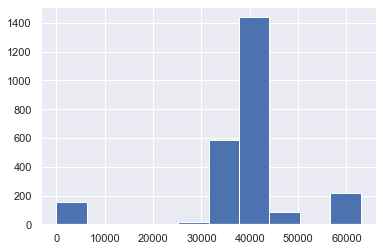

In [211]:
plt.hist(df_hh2.zip_code)

In [212]:
df_hh2.shape

(2498, 59)

(array([  4.,   0.,   0.,   0.,   0.,  40., 100.,   8.,   0.,  14.]),
 array([    0. ,  6295.9, 12591.8, 18887.7, 25183.6, 31479.5, 37775.4,
        44071.3, 50367.2, 56663.1, 62959. ]),
 <BarContainer object of 10 artists>)

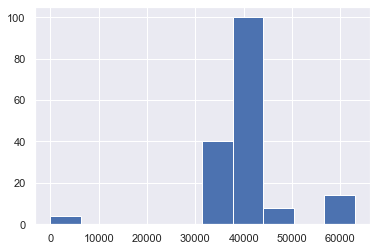

In [213]:
plt.hist(df_hh2_demo[df_hh2_demo.redeemed_campA_18==1].zip_code)